In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, json, sys

In [3]:
os.environ["INCLUDEVAL_UPTO"] = "4"

In [4]:
os.environ["WHICHMODEL"] ="stepbest"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [ ]:
class FakeArgsHome0old():
    seed = 0
    dataset = "OfficeHome"
    test_env = 0
    train_envs = []
    output_dir = ["/data/rame/experiments/domainbed/home0_ma_lp_0824"]
    trial_seed = 0
    data_dir = "/data/rame/data/domainbed"
    checkpoints= [
        {
            "name": "/data/rame/data/domainbed/inits/model_home0_ermll_saveall_si_0822.pkl", "weight": 0, "type": "featurizer",
        },
        {"name": "/data/rame/data/domainbed/inits/dn1_erm02345_lp_r0_0921.pkl", "weight": 0, "type": "featurizeronly"
},
        {"name": "/data/rame/fb/iwild_ermf_lp_r0_t0_0926.pkl", "weight": 0, "type": "featurizeronly"}
    ]
    weighting = "norm"
    weight_selection = "train"
    topk = 1
    what = ["addfeats"]
    hparams = json.loads('{"do_feats": 1.0}')

In [ ]:
class FakeArgsHome0():
    seed = 0
    dataset = "OfficeHome"
    test_env = 0
    train_envs = []
    output_dir = ["/data/rame/fb/home0_ermf_lp_0926"]
    trial_seed = 0
    data_dir = "/data/rame/data/domainbed"
    checkpoints= [
        {
            "name": "/data/rame/fb/home0_lp_0926.pkl", "weight": 0, "type": "featurizer",
        },
        {"name": "/data/rame/fb/dn_ermf_lp_r0_t0_0926.pkl", "weight": 0, "type": "featurizeronly"
        },
        {"name": "/data/rame/fb/iwild_ermf_lp_r0_t0_0926.pkl", "weight": 0, "type": "featurizeronly"}
    ]
    weighting = "norm"
    weight_selection = "train"
    topk = 1
    what = ["addfeats"]
    hparams = json.loads('{"do_feats": 1.0}')

In [5]:
class FakeArgsTerra1():
    seed = 0
    dataset = "TerraIncognita"
    test_env = 1
    train_envs = []
    output_dir = ["/data/rame/fb/terra1_ermf_lp_0926"]
    trial_seed = 0
    data_dir = "/data/rame/data/domainbed"
    checkpoints= [
        {
            "name": "/data/rame/fb/terra1_lp_0926.pkl", "weight": 0, "type": "featurizer",
        },
        {"name": "/data/rame/fb/dn_ermf_lp_r0_t0_0926.pkl", "weight": 0, "type": "featurizeronly"
        },
        {"name": "/data/rame/fb/iwild_ermf_lp_r0_t0_0926.pkl", "weight": 0, "type": "featurizeronly"}
    ]
    weighting = "norm"
    weight_selection = "train"
    topk = 1
    what = ["addfeats"]
    hparams = json.loads('{"do_feats": 1.0}')

In [6]:
inf_args = FakeArgsTerra1()

In [7]:
sys.path.append("/home/rame/domainbedv2")

In [8]:
from domainbed.scripts import diwa

/home/rame/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import argparse
import os
import json
import random
import numpy as np
import torch
import torch.utils.data
from domainbed import datasets, algorithms_inference
from domainbed.lib import misc
from domainbed.lib.fast_data_loader import FastDataLoader, InfiniteDataLoader
from domainbed.lib import misc

In [10]:
device = "cuda"
random.seed(inf_args.seed)
np.random.seed(inf_args.seed)
torch.manual_seed(inf_args.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
dataset_class = vars(datasets)[inf_args.dataset]
dataset = dataset_class(
    inf_args.data_dir, [inf_args.test_env],
    hparams={"data_augmentation": os.environ.get("DATAAUG", "0") == "1"}

)

In [12]:
list_dict_checkpoint_to_score_i = []
for output_dir in inf_args.output_dir:
    list_dict_checkpoint_to_score_i.append(
        diwa.get_dict_checkpoint_to_score(output_dir, inf_args, train_envs=inf_args.train_envs, device=device)
    )

In [13]:
dict_checkpoint_to_score, sorted_checkpoints = diwa.merge_checkpoints(
    inf_args, list_dict_checkpoint_to_score_i
)
dict_data_splits = diwa.create_data_splits(inf_args, dataset)

Found:  /data/rame/fb/terra1_ermf_lp_0926/956e1dc49b49e71b9c22b2247dab508a/model_best.pkl  with score:  0.9051616113503188


In [14]:
selected_checkpoints = [
        {
            "name": checkpoint,
            "weight": diwa.weighting_checkpoint(
                checkpoint, inf_args.weighting, dict_checkpoint_to_score,
                len(sorted_checkpoints)),
            "type": "network"
        } for checkpoint in sorted_checkpoints
    ]

In [15]:
wa_algorithm = algorithms_inference.TrainableDiWA(
    dataset.input_shape,
    dataset.num_classes,
    len(dataset) - 1,
    hparams=inf_args.hparams
)

In [16]:

dict_data_loaders = {
    name: FastDataLoader(dataset=split, batch_size=64, num_workers=0, use_random=False)
    for name, split in dict_data_splits.items()
}

In [17]:
diwa.load_and_update_networks(
    wa_algorithm, selected_checkpoints, dataset, action=["addfeats", "feats", "cla"], device=device
)

/home/rame/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/rame/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load algorithm /data/rame/fb/terra1_ermf_lp_0926/956e1dc49b49e71b9c22b2247dab508a/model_best.pkl 1.0 network


In [18]:

diwa.load_and_update_networks(
    wa_algorithm, inf_args.checkpoints, dataset, action=["addfeats"], device=device
)

Load network /data/rame/fb/terra1_lp_0926.pkl 0 featurizer
Load featurizer /data/rame/fb/dn_ermf_lp_r0_t0_0926.pkl 0 featurizeronly
Load featurizer /data/rame/fb/iwild_ermf_lp_r0_t0_0926.pkl 0 featurizeronly


In [19]:
wa_algorithm.to(device)
wa_algorithm.eval()

In [20]:
wa_algorithm.num_aux = len(wa_algorithm.featurizers)
wa_algorithm._init_lambdas()

In [21]:
wa_algorithm.lambdas

tensor([1., 0., 0., 0.], requires_grad=True)

In [22]:
dict_results = {}

for name in dict_data_loaders.keys():
    loader = dict_data_loaders[name]
    do_feats = inf_args.hparams.get("do_feats") and name.startswith("env_") and name.endswith("_out")
    if not do_feats:
        print(f"Skip at {name}")
        continue
    else:
        print(f"Prediction at {name}")
    wa_algorithm.eval()
    dict_stats, aux_dict_stats = wa_algorithm.get_dict_prediction_stats(
        loader, device, what=["mean_feats", "cov_feats"],
        predict_kwargs={"lambdas": torch.tensor([1, 0., 0., 0.], device=device)}
    )
    dict_results[name] = dict_stats["11"]["acc"]

    if do_feats:
        domain = name.split("_")[1]
        wa_algorithm.domain_to_mean_feats[domain] = aux_dict_stats["mean_feats"]
        wa_algorithm.domain_to_cov_feats[domain] = aux_dict_stats["cov_feats"]

Skip at testout
Skip at test
Prediction at env_0_out
Prediction at env_1_out
Prediction at env_2_out
Prediction at env_3_out


In [23]:
wa_algorithm.domain_to_mean_feats["all"] = torch.mean(
    torch.stack(
        [value for key, value in wa_algorithm.domain_to_mean_feats.items() if key != str(int(inf_args.test_env))
        ], dim=0), dim=0)

In [24]:
wa_algorithm.domain_to_mean_feats

{'0': tensor([[1.0624, 1.3943, 0.2397,  ..., 0.4864, 0.5954, 0.7954]],
        device='cuda:0'),
 '1': tensor([[0.5595, 1.1214, 0.1158,  ..., 0.4182, 0.5763, 0.7053]],
        device='cuda:0'),
 '2': tensor([[0.7239, 0.6075, 0.1205,  ..., 0.3757, 0.5710, 0.5329]],
        device='cuda:0'),
 '3': tensor([[0.6928, 0.6535, 0.1144,  ..., 0.3924, 0.4473, 0.5592]],
        device='cuda:0'),
 'all': tensor([[0.8264, 0.8851, 0.1582,  ..., 0.4182, 0.5379, 0.6292]],
        device='cuda:0')}

In [31]:
ds = {}
aux = {}

domain = str(int(inf_args.test_env))
loader = dict_data_loaders["env_"+ domain + "_out"]

for lam in [0.0, 0.1, 0.2, 0.5, 1.0, 1.5, 2, 5, 10, 20]:
    wa_algorithm.eval()
    loader.restart()
    lambdas = [1., 0., lam, 0.]
    key_lambdas = "_".join([str(lam) for lam in lambdas])

    ds[key_lambdas], aux[key_lambdas] = wa_algorithm.get_dict_prediction_stats(
        loader, device, what=["mean_feats", "cov_feats", "l2_feats", "l2var_feats"],
        predict_kwargs={"domain": domain,
                        "lambdas": torch.tensor(lambdas, device=device)}
    )

In [35]:
for lam in [0.0, 0.05, 0.1, 0.2, 0.5, 1.0, 1.5, 2, 5, 10, 20]:
    wa_algorithm.eval()
    loader.restart()
    lambdas = [1., 0, 0., lam]
    key_lambdas = "_".join([str(lam) for lam in lambdas])

    ds[key_lambdas], aux[key_lambdas] = wa_algorithm.get_dict_prediction_stats(
        loader, device, what=["mean_feats", "cov_feats", "l2_feats", "l2var_feats"],
        predict_kwargs={"domain": domain,
                        "lambdas": torch.tensor(lambdas, device=device)}
    )

In [ ]:
for lam in [0.0, 0.1, 0.2, 0.5, 1.0, 1.5, 2, 5, 10, 20]:
    wa_algorithm.eval()
    loader.restart()
    lambdas = [1., lam, 0., 0.]
    key_lambdas = "_".join([str(lam) for lam in lambdas])

    ds[key_lambdas], aux[key_lambdas] = wa_algorithm.get_dict_prediction_stats(
        loader, device, what=["mean_feats", "cov_feats", "l2_feats", "l2var_feats"],
        predict_kwargs={"domain": domain,
                        "lambdas": torch.tensor(lambdas, device=device)}
    )

In [36]:
dict_results = {}
# misc.print_row(["key_lambdas", "acc", "dis_means", "dis_vars", "l2_to_2", "l2var_to_2", "ent", "bdi"], 20)
for key_lambdas in ds:
    acc = ds[key_lambdas]["11"]["acc"]
    dis_means = (aux[key_lambdas]["mean_feats"] - wa_algorithm.domain_to_mean_feats["all"]).pow(2).mean().detach().cpu().numpy()
    l2_to_all = aux[key_lambdas]["l2_all"].detach().cpu().numpy()
    l2var_to_all = aux[key_lambdas]["l2var_all"].detach().cpu().numpy()
    dict_entropy = misc.get_dict_entropy(ds[key_lambdas], device)
    #misc.print_row([key_lambdas, acc, dis_means, dis_vars, l2_to_2, l2var_to_2, dict_entropy["ent_11"], dict_entropy["bdi_11"]], 20)
    dict_results[key_lambdas] = {
        "lambdas": [float(l) for l in key_lambdas.split("_")],
        "l2+ent": l2var_to_all + dict_entropy["ent_11"],
        "key_lambdas": key_lambdas, "acc": acc, "dis_means": dis_means, "l2_to_all": l2_to_all, "l2var_to_all": l2var_to_all, "ent": dict_entropy["ent_11"], "bdi": dict_entropy["bdi_11"]
         }

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

plt.rcParams["figure.figsize"] = (8, 5)


def plot_slopes_c(x, ys1, ys2, labels):
    fig, ax1 = plt.subplots()
    plt.xlabel("Lambda", fontsize="x-large")


    #plot.fit_and_plot_with_value(m, erm[key], order="2", label=None, color=colors[0], ax=None)
    colors = cm.rainbow(np.linspace(0.2, 1, len(ys1) + len(ys2)))
    for i in range(len(ys1)):
        ax1.scatter(x, ys1[i], label=labels[i], color=colors[i], marker=".")
        #fit_and_plot_with_value(x, ys1[i], 2, labels[i], colors[i], ax1, linestyle="-")
        
    ax1.legend(fontsize="x-large", loc="lower left")

    ax2 = ax1.twinx()
    for i in range(len(ys2)):
        j = i + len(ys1)
        ax2.scatter(x, ys2[i], label=labels[j], color=colors[j], marker="x")
        #fit_and_plot_with_value(x, ys2[i], "2", labels[j], colors[j], ax2, linestyle="--")

    ax2.legend(fontsize="x-large", loc="lower right")
    return fig

def plot_slopes(key, check):
    list_results = dict_results.values()
    x = [r["lambdas"][key] for r in list_results if check(r)]
    labels = ["acc", "ent", "l2_to_all", "l2var_to_all"]
    labels = ["acc", "ent", "l2_to_all"]#, "l2+ent", "dis_means"]
    ys = [
        [r[label] for r in list_results if check(r)]
        for label in labels]

    fig = plot_slopes_c(x, ys[:1], ys[1:], labels)

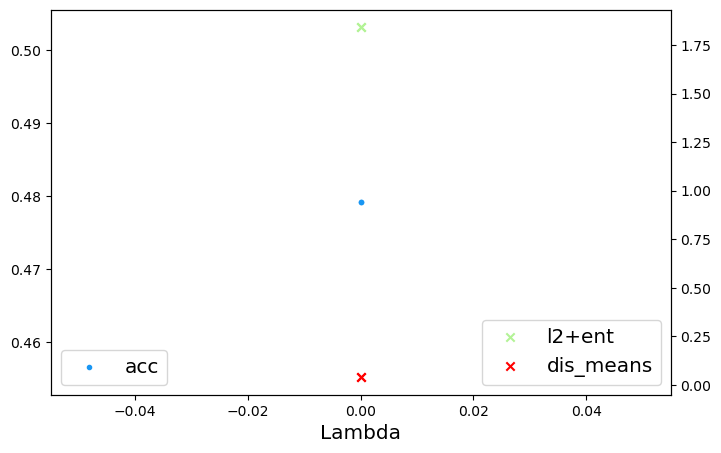

In [38]:
def check(r):
    return r["lambdas"][2] == 0 and r["lambdas"][3] == 0
plot_slopes(1, check)

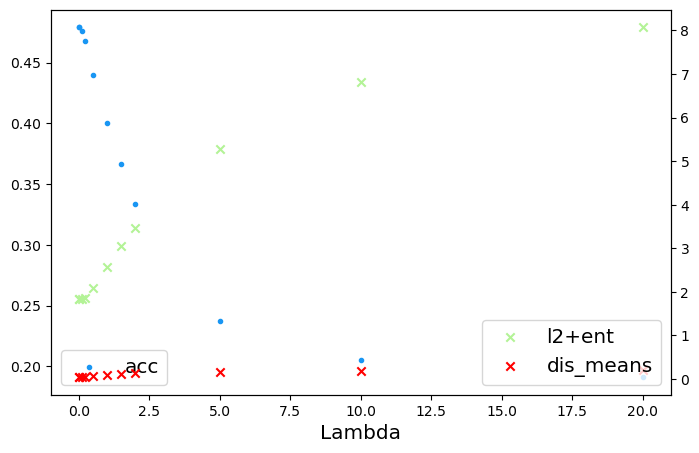

In [39]:
def check(r):
    return r["lambdas"][1] == 0 and r["lambdas"][3] == 0
plot_slopes(2, check)

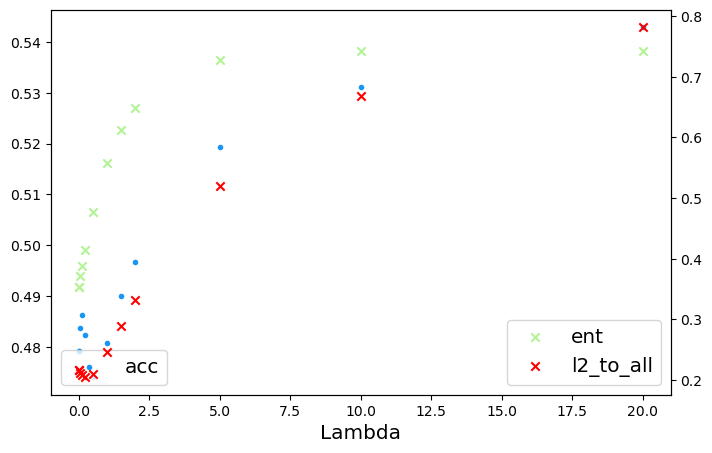

In [46]:
def check(r):
    return r["lambdas"][1] == 0 and r["lambdas"][2] == 0
plot_slopes(3, check)

In [ ]:
dict_entropy

In [ ]:

torch.mean(torch.diag(aux["1_0_0.0"]["cov_feats"]))